In [1]:
%matplotlib inline
import pandas as pd
import dask.dataframe as dd
from dask_ml.preprocessing import DummyEncoder
import numpy as np
import altair as alt
import seaborn as sns
import math

from mpl_toolkits.mplot3d import Axes3D
from matplotlib import pyplot as plt

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_auc_score
from sklearn import metrics

from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans

from sklearn.linear_model import LinearRegression
from sklearn import svm


plt.style.use('ggplot')

# Crime Classification in San Francisco
## Multi-class classification
https://www.kaggle.com/c/sf-crime

"From 1934 to 1963, San Francisco was infamous for housing some of the world's most notorious criminals on the inescapable island of Alcatraz.

Today, the city is known more for its tech scene than its criminal past. But, with rising wealth inequality, housing shortages, and a proliferation of expensive digital toys riding BART to work, there is no scarcity of crime in the city by the bay.

From Sunset to SOMA, and Marina to Excelsior, this competition's dataset provides nearly 12 years of crime reports from across all of San Francisco's neighborhoods. Given time and location, you must predict the category of crime that occurred."


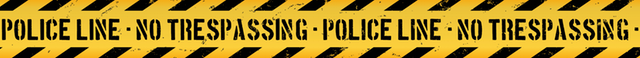

In [2]:
# 878049 rows x 9 columns
data = pd.read_csv('crimetrain.csv', parse_dates=['Dates'])
# train = pd.read_csv('crimetrain.csv')
data.head()

,Dates,Category,Descript,DayOfWeek,PdDistrict,Resolution,Address,X,Y
0,2015-05-13 23:53:00,WARRANTS,WARRANT ARREST,Wednesday,NORTHERN,"ARREST, BOOKED",OAK ST / LAGUNA ST,-122.425892,37.774599
1,2015-05-13 23:53:00,OTHER OFFENSES,TRAFFIC VIOLATION ARREST,Wednesday,NORTHERN,"ARREST, BOOKED",OAK ST / LAGUNA ST,-122.425892,37.774599
2,2015-05-13 23:33:00,OTHER OFFENSES,TRAFFIC VIOLATION ARREST,Wednesday,NORTHERN,"ARREST, BOOKED",VANNESS AV / GREENWICH ST,-122.424363,37.800414
3,2015-05-13 23:30:00,LARCENY/THEFT,GRAND THEFT FROM LOCKED AUTO,Wednesday,NORTHERN,NONE,1500 Block of LOMBARD ST,-122.426995,37.800873
4,2015-05-13 23:30:00,LARCENY/THEFT,GRAND THEFT FROM LOCKED AUTO,Wednesday,PARK,NONE,100 Block of BRODERICK ST,-122.438738,37.771541


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 878049 entries, 0 to 878048
Data columns (total 9 columns):
Dates         878049 non-null datetime64[ns]
Category      878049 non-null object
Descript      878049 non-null object
DayOfWeek     878049 non-null object
PdDistrict    878049 non-null object
Resolution    878049 non-null object
Address       878049 non-null object
X             878049 non-null float64
Y             878049 non-null float64
dtypes: datetime64[ns](1), float64(2), object(6)
memory usage: 60.3+ MB


In [4]:
print("Num of Categories: ", data['Category'].nunique())
print("Num of Descripts: ", data['Descript'].nunique())

Num of Categories:  39
Num of Descripts:  879


In [5]:
data.Resolution.unique()

array(['ARREST, BOOKED', 'NONE', 'ARREST, CITED', 'PSYCHOPATHIC CASE',
       'JUVENILE BOOKED', 'UNFOUNDED', 'EXCEPTIONAL CLEARANCE', 'LOCATED',
       'CLEARED-CONTACT JUVENILE FOR MORE INFO', 'NOT PROSECUTED',
       'JUVENILE DIVERTED', 'COMPLAINANT REFUSES TO PROSECUTE',
       'JUVENILE ADMONISHED', 'JUVENILE CITED',
       'DISTRICT ATTORNEY REFUSES TO PROSECUTE',
       'PROSECUTED BY OUTSIDE AGENCY', 'PROSECUTED FOR LESSER OFFENSE'],
      dtype=object)

- TREA = Trespassing or loitering near posted industrial property

# Exploratory Data Analysis

In [6]:
encodeddata = pd.read_csv('crimetrain.csv')
labelencoder = LabelEncoder()
for col in encodeddata.columns:
    encodeddata[col] = labelencoder.fit_transform(encodeddata[col])

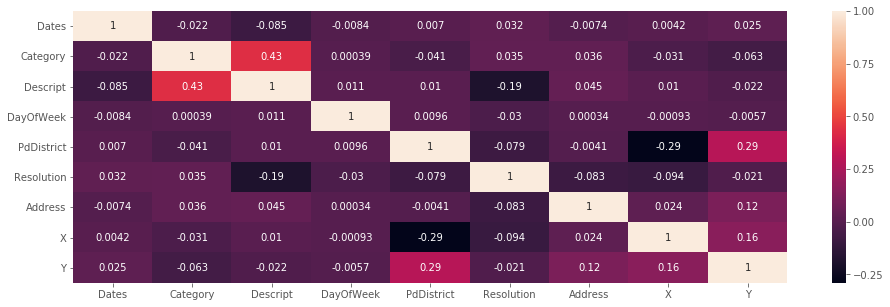

In [7]:
plt.figure(figsize = (16,5))
ax = sns.heatmap(encodeddata.corr(), annot=True)

## What is the most popular crime?

In [8]:
data = pd.read_csv('crimetrain.csv', parse_dates=['Dates'])

Text(0,0.5,'count')

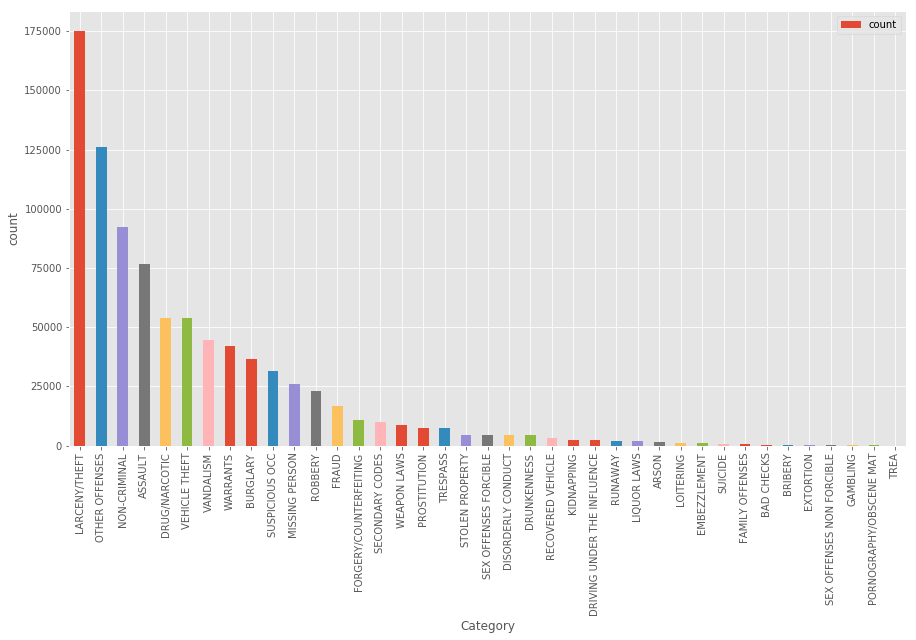

In [9]:
popcrime = data.groupby('Category').count().reset_index()
popcrime = popcrime.drop(['Dates', 'Descript', 'DayOfWeek', 'PdDistrict', 'Resolution', 'Address', 'X'], axis=1)
popcrime = popcrime.rename(columns={'Y':'count'}).sort_values(by='count', ascending=False)
popcrime.plot.bar(x='Category', y='count', figsize=(15, 8))
plt.ylabel("count")

## What district is the most dangerous?

Text(0,0.5,'Number of Crimes')

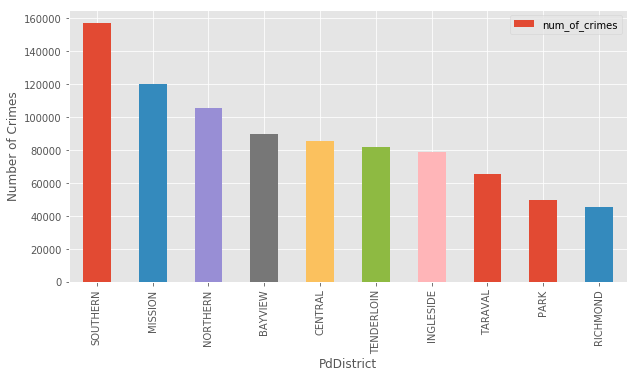

In [10]:
dangerous = data.groupby('PdDistrict').count().reset_index()
dangerous = dangerous.drop(['Dates', 'Category', 'Descript', 'DayOfWeek', 'Resolution', 'Address', 'X'], axis=1)
dangerous = dangerous.rename(columns={'Y':'num_of_crimes'}).sort_values(by='num_of_crimes', ascending=False)
dangerous.plot.bar(x='PdDistrict', y='num_of_crimes', figsize=(10, 5))
plt.ylabel('Number of Crimes')

## PdDistrict and Category

/usr/local/lib/python3.5/site-packages/matplotlib/pyplot.py:537: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


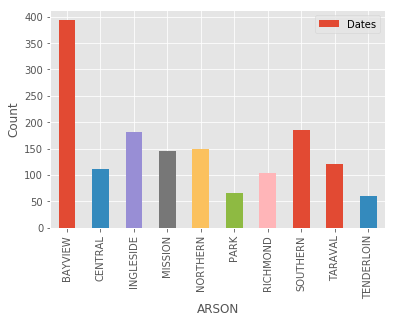

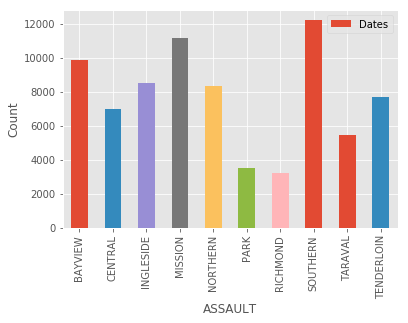

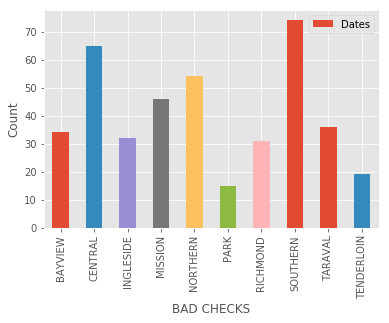

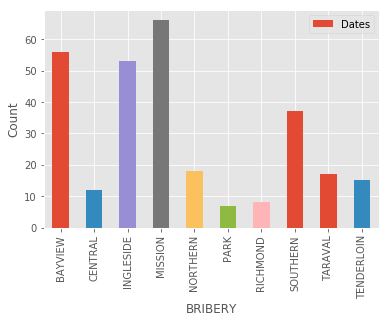

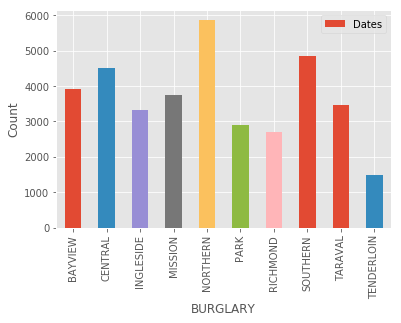

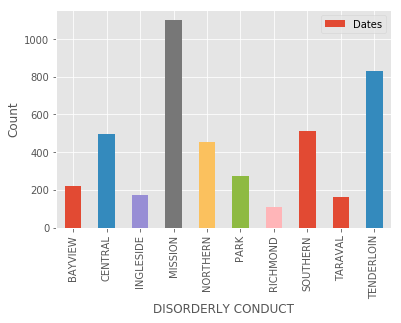

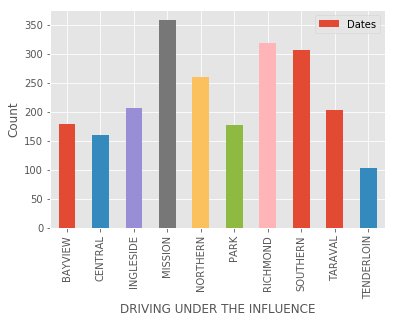

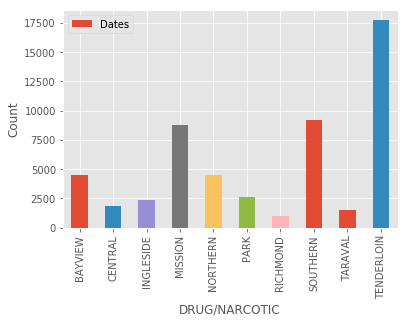

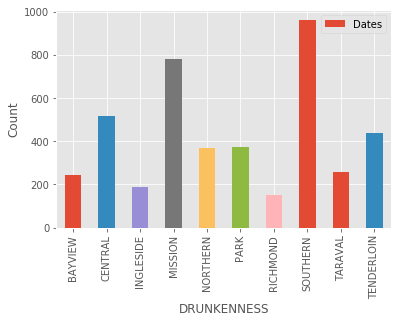

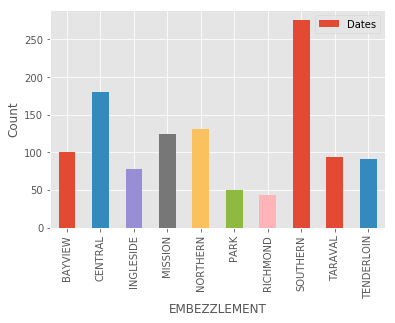

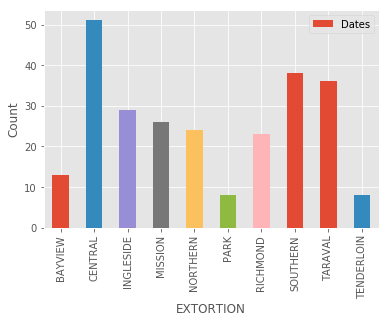

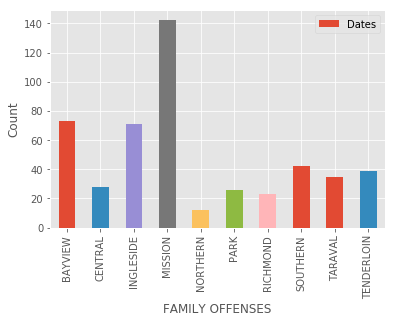

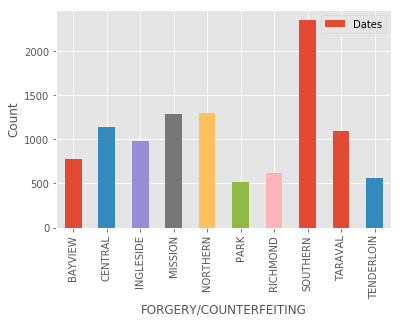

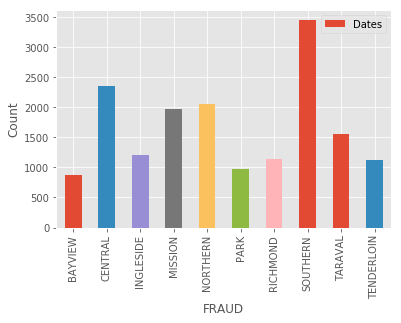

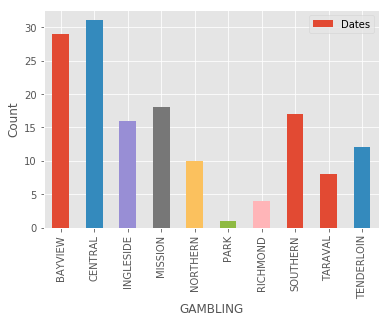

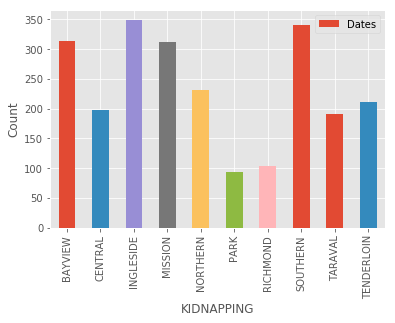

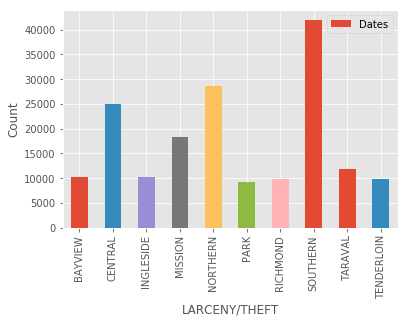

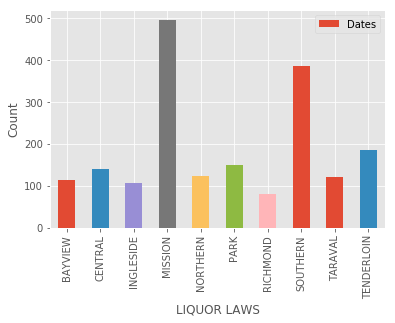

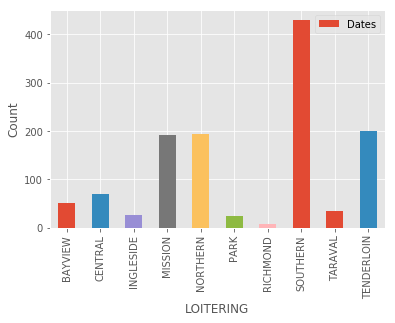

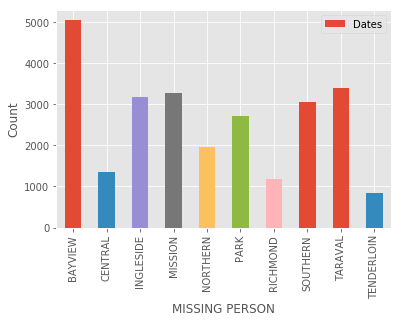

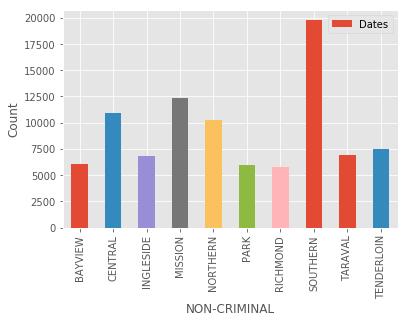

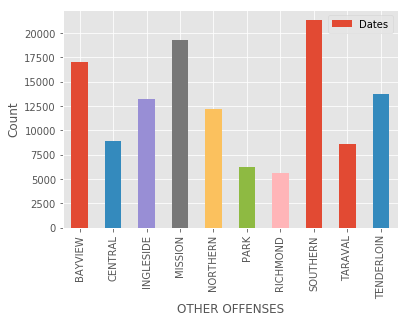

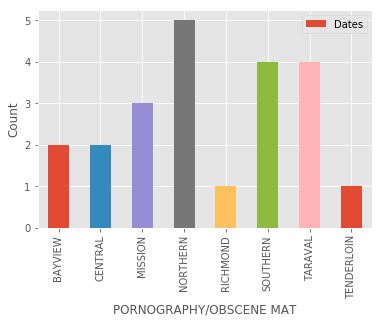

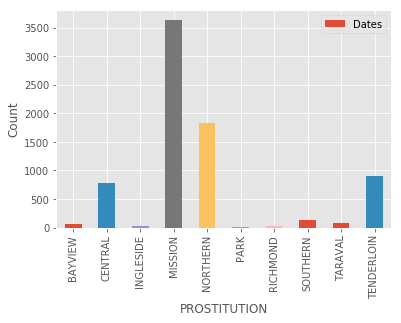

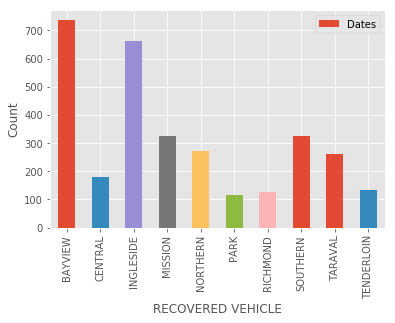

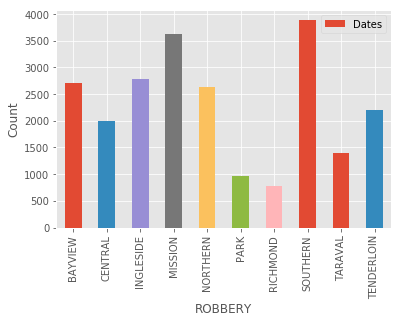

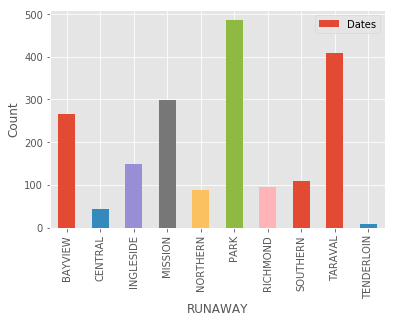

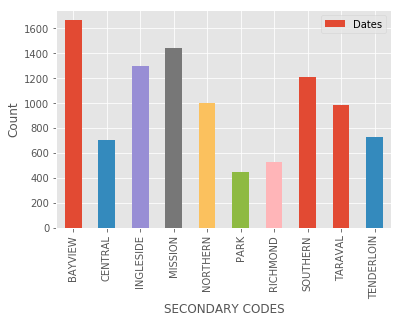

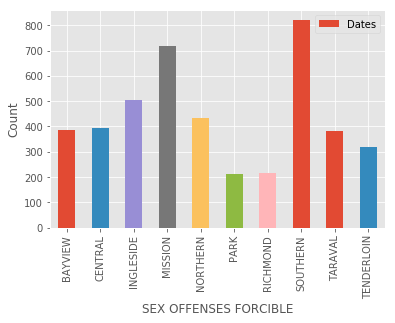

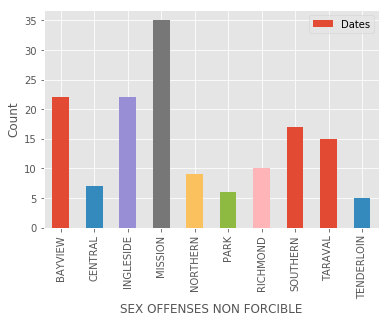

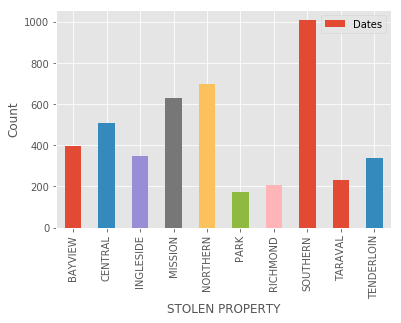

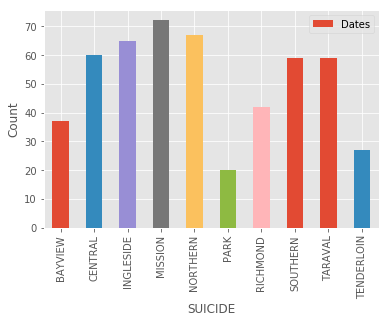

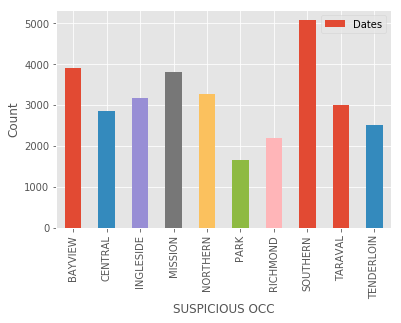

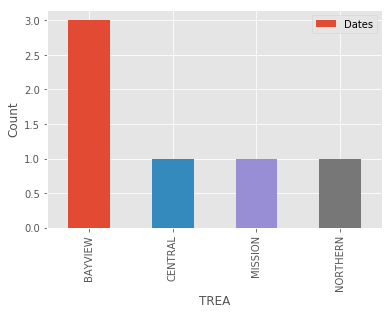

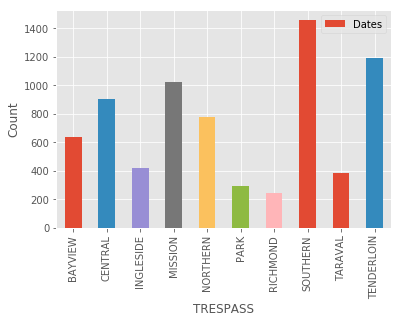

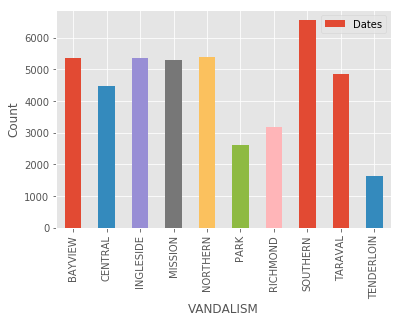

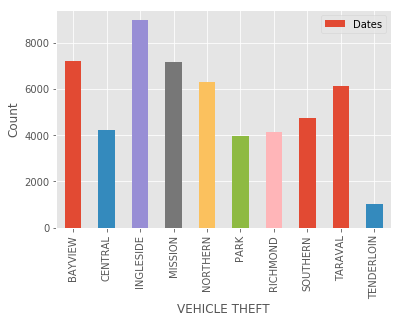

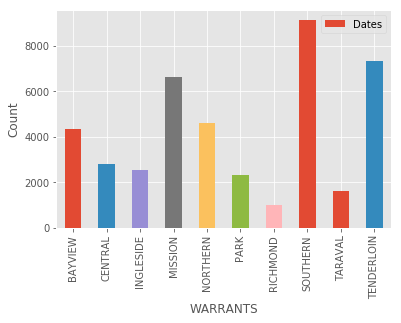

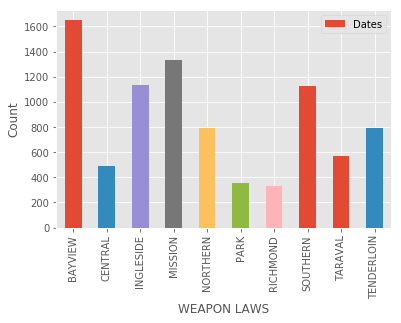

In [11]:
cpddist = data.groupby(['Category', 'PdDistrict']).count().reset_index()
for category in cpddist['Category'].unique():
    ddata = cpddist[cpddist['Category'] == category]
    ddata.plot.bar(x='PdDistrict', y='Dates') # doesn't matter which, just looking at count
    plt.xlabel(category)
    plt.ylabel('Count')

## Percentage of crime by PdDistrict

In [12]:
data.head()

,Dates,Category,Descript,DayOfWeek,PdDistrict,Resolution,Address,X,Y
0,2015-05-13 23:53:00,WARRANTS,WARRANT ARREST,Wednesday,NORTHERN,"ARREST, BOOKED",OAK ST / LAGUNA ST,-122.425892,37.774599
1,2015-05-13 23:53:00,OTHER OFFENSES,TRAFFIC VIOLATION ARREST,Wednesday,NORTHERN,"ARREST, BOOKED",OAK ST / LAGUNA ST,-122.425892,37.774599
2,2015-05-13 23:33:00,OTHER OFFENSES,TRAFFIC VIOLATION ARREST,Wednesday,NORTHERN,"ARREST, BOOKED",VANNESS AV / GREENWICH ST,-122.424363,37.800414
3,2015-05-13 23:30:00,LARCENY/THEFT,GRAND THEFT FROM LOCKED AUTO,Wednesday,NORTHERN,NONE,1500 Block of LOMBARD ST,-122.426995,37.800873
4,2015-05-13 23:30:00,LARCENY/THEFT,GRAND THEFT FROM LOCKED AUTO,Wednesday,PARK,NONE,100 Block of BRODERICK ST,-122.438738,37.771541


In [13]:
# adding a total column
perct = pd.crosstab([data.Category], data.PdDistrict).reset_index()
perct['total'] = perct.sum(axis=1)

# calculating percent for each row        
for district in data.PdDistrict.unique():
    perct[district+'%'] = perct.apply(lambda perct: perct[district]/perct.total*100, axis=1)

# dropping unncessary columns
perct = perct.drop(['BAYVIEW', 'CENTRAL', 'INGLESIDE', 'MISSION', 'NORTHERN', 'PARK', 'RICHMOND', 'SOUTHERN', 'TARAVAL', 'TENDERLOIN', 'total'], axis=1)
perct.head()

PdDistrict,Category,NORTHERN%,PARK%,INGLESIDE%,BAYVIEW%,RICHMOND%,CENTRAL%,TARAVAL%,TENDERLOIN%,MISSION%,SOUTHERN%
0,ARSON,9.847984,4.296100,12.029081,25.974884,6.807667,7.336418,7.931262,3.965631,9.583609,12.227363
1,ASSAULT,10.820022,4.572298,11.099693,12.821947,4.165149,9.075654,7.106249,9.988813,14.502576,15.847599
2,BAD CHECKS,13.300493,3.694581,7.881773,8.374384,7.635468,16.009852,8.866995,4.679803,11.330049,18.226601
3,BRIBERY,6.228374,2.422145,18.339100,19.377163,2.768166,4.152249,5.882353,5.190311,22.837370,12.802768
4,BURGLARY,15.927085,7.857434,9.062713,10.692423,7.335056,12.294926,9.421847,4.048429,10.189090,13.170997


/usr/local/lib/python3.5/site-packages/pandas/plotting/_core.py:1716: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  series.name = label


Text(0,0.5,'% of PdDistrict')

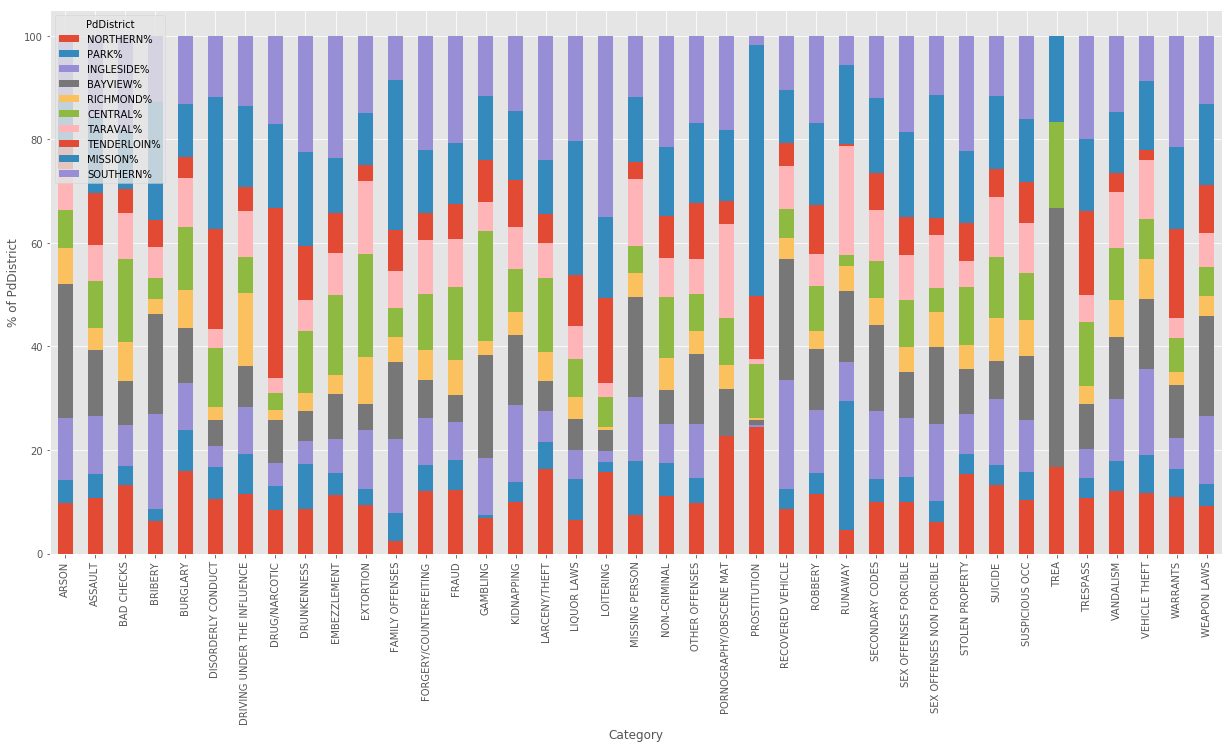

In [14]:
perct.plot.bar(x='Category', y=['NORTHERN%', 'PARK%', 'INGLESIDE%', 'BAYVIEW%', 'RICHMOND%', 'CENTRAL%', 'TARAVAL%', 'TENDERLOIN%', 'MISSION%', 'SOUTHERN%'], stacked=True, figsize=(21,10))
plt.ylabel('% of PdDistrict')

/usr/local/lib/python3.5/site-packages/pandas/plotting/_core.py:1716: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  series.name = label


Text(0,0.5,'% of PdDistrict')

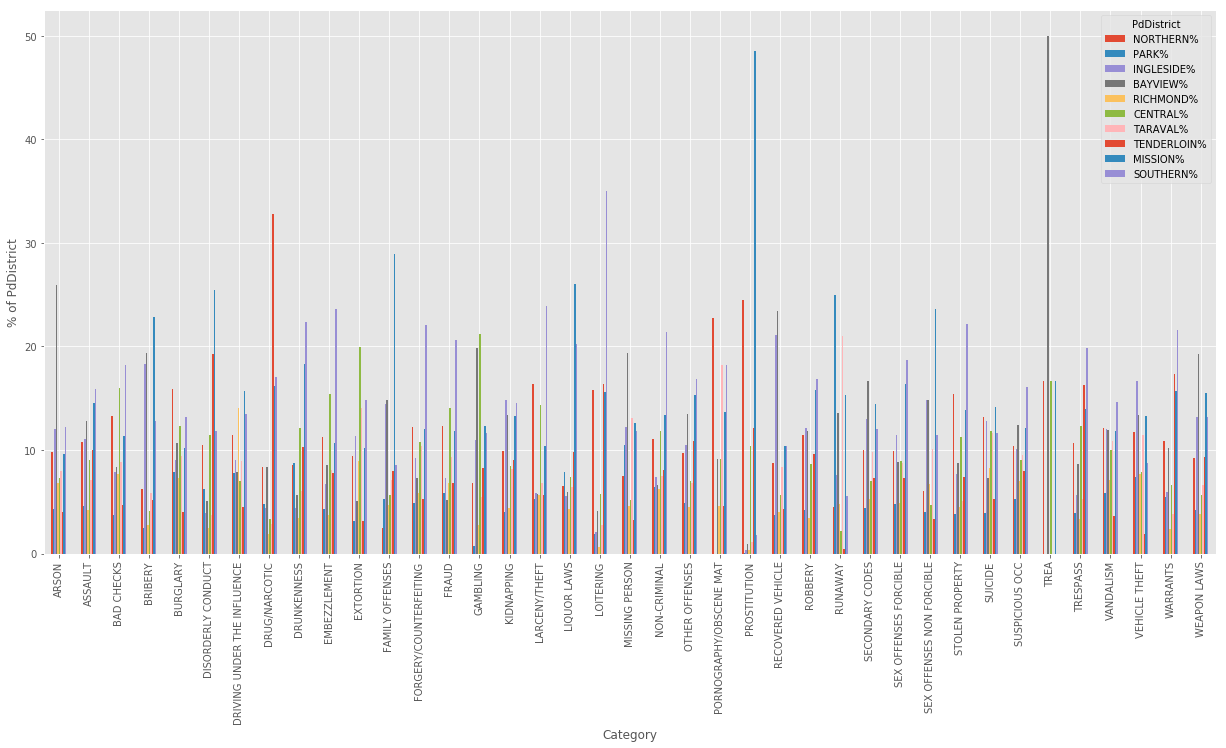

In [15]:
perct.plot.bar(x='Category', y=['NORTHERN%', 'PARK%', 'INGLESIDE%', 'BAYVIEW%', 'RICHMOND%', 'CENTRAL%', 'TARAVAL%', 'TENDERLOIN%', 'MISSION%', 'SOUTHERN%'], figsize=(21,10))
plt.ylabel('% of PdDistrict')

In [16]:
# what district is the hightest for prostitution? --it's hard to tell looking at the graph so let's pull up the table
p = data[data['Category'] == 'PROSTITUTION'].groupby(['Category', 'PdDistrict']).count().reset_index().sort_values(by='Dates', ascending=False)
p = p.drop(['Dates', 'Descript', 'DayOfWeek', 'Resolution', 'Address', 'X'], axis=1)
p = p.rename(columns={'Y':'count'}).sort_values(by='count', ascending=False)
p

,Category,PdDistrict,count
3,PROSTITUTION,MISSION,3629
4,PROSTITUTION,NORTHERN,1831
9,PROSTITUTION,TENDERLOIN,904
1,PROSTITUTION,CENTRAL,778
7,PROSTITUTION,SOUTHERN,135
8,PROSTITUTION,TARAVAL,82
0,PROSTITUTION,BAYVIEW,70
2,PROSTITUTION,INGLESIDE,26
6,PROSTITUTION,RICHMOND,24
5,PROSTITUTION,PARK,5


### Takeaways
- PdDistrict may not be the best indicator of Category, but there are definitely some PdDistricts where certain crimes occur more so than others

## Category and Descript

In [17]:
descript = data.groupby(['Category', 'Descript']).count().reset_index()
descript = descript.drop(['Dates', 'DayOfWeek', 'PdDistrict', 'Resolution', 'Address', 'X'], axis=1)
descript = descript.rename(columns={'Y':'count'}).sort_values(by='count', ascending=False)
descript.head(n=10)

,Category,Descript,count
333,LARCENY/THEFT,GRAND THEFT FROM LOCKED AUTO,60022
432,NON-CRIMINAL,LOST PROPERTY,31729
39,ASSAULT,BATTERY,27441
819,VEHICLE THEFT,STOLEN AUTOMOBILE,26897
469,OTHER OFFENSES,"DRIVERS LICENSE, SUSPENDED OR REVOKED",26839
842,WARRANTS,WARRANT ARREST,23754
780,SUSPICIOUS OCC,SUSPICIOUS OCCURRENCE,21891
411,NON-CRIMINAL,"AIDED CASE, MENTAL DISTURBED",21497
349,LARCENY/THEFT,PETTY THEFT FROM LOCKED AUTO,19771
811,VANDALISM,"MALICIOUS MISCHIEF, VANDALISM OF VEHICLES",17789


## Time Series  

In [18]:
timedata = pd.read_csv('crimetrain.csv', parse_dates=['Dates'])

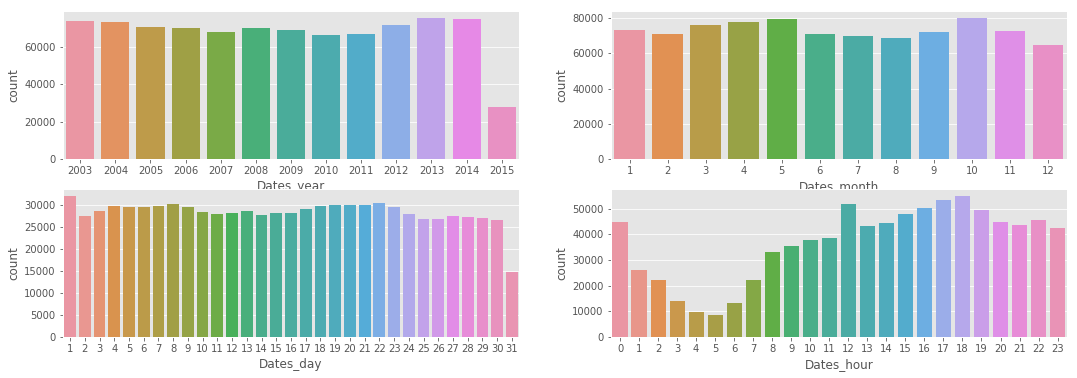

In [19]:
timedata['Dates_year'] = timedata['Dates'].dt.year
timedata['Dates_month'] = timedata['Dates'].dt.month
timedata['Dates_day'] = timedata['Dates'].dt.day
timedata['Dates_hour'] = timedata['Dates'].dt.hour

fig, ((axis1,axis2),(axis3,axis4)) = plt.subplots(nrows=2, ncols=2)
fig.set_size_inches(18,6)

sns.countplot(data=timedata, x='Dates_year', ax=axis1)
sns.countplot(data=timedata, x='Dates_month', ax=axis2)
sns.countplot(data=timedata, x='Dates_day', ax=axis3)
sns.countplot(data=timedata, x='Dates_hour', ax=axis4)

### Takeaways
- Why are the number of crimes for 2015 so low?
- Number of crimes relatively the same from day to day except for the first of the month and the 31 (because not all months have 31 days)
- Crimes by hour pretty interesting. Descreases from midnight to 5:00am and steadily increases from 8:00am to 6:00pm with a spike at noon

/usr/local/lib/python3.5/site-packages/matplotlib/pyplot.py:537: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


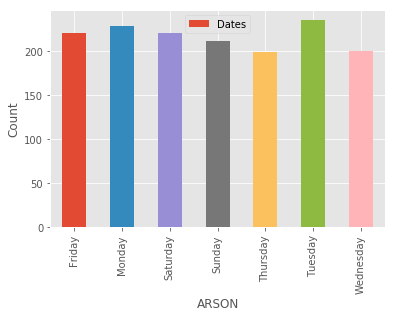

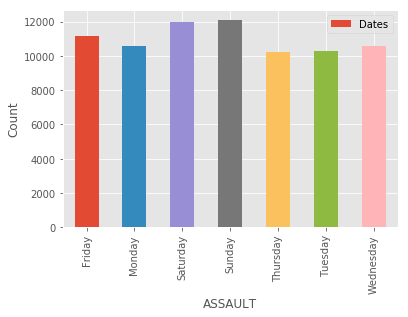

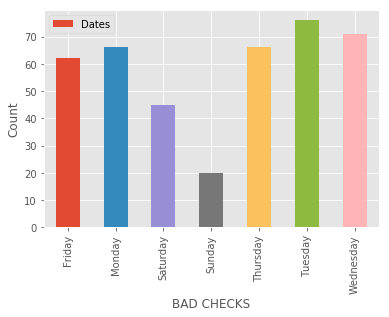

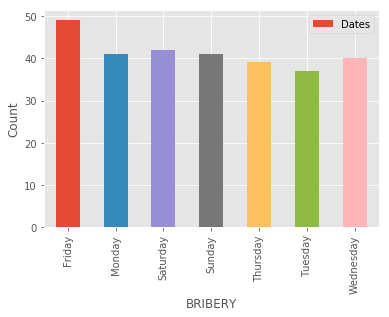

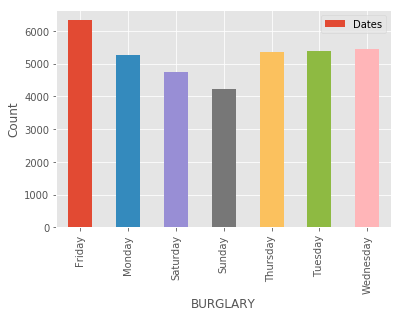

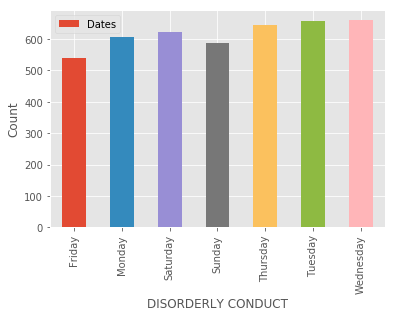

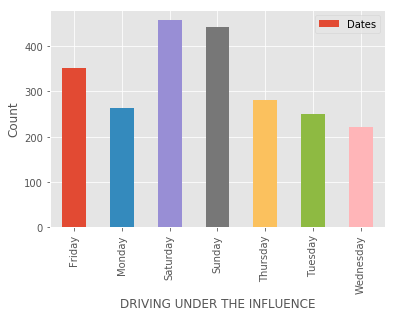

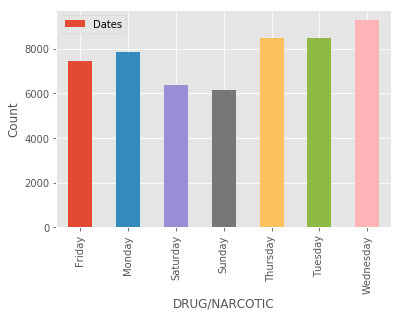

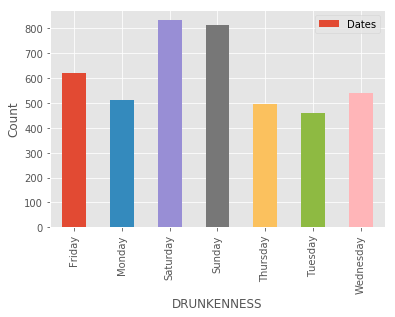

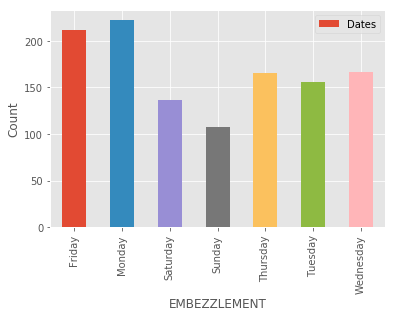

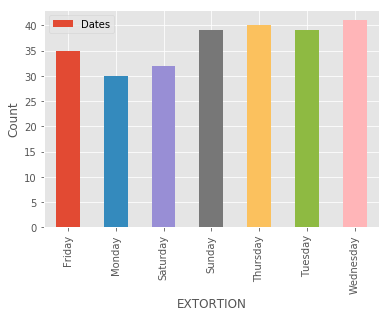

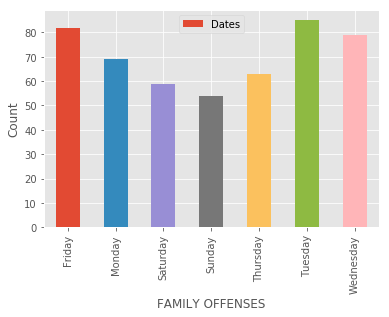

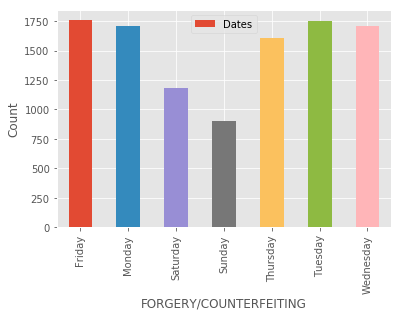

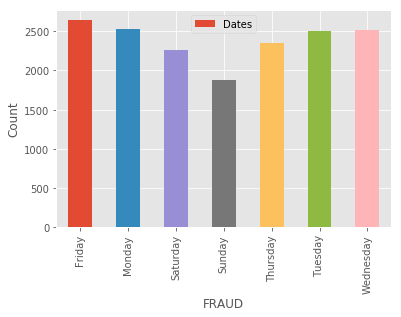

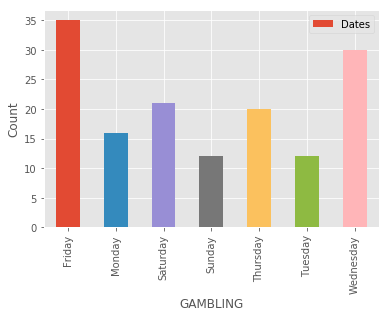

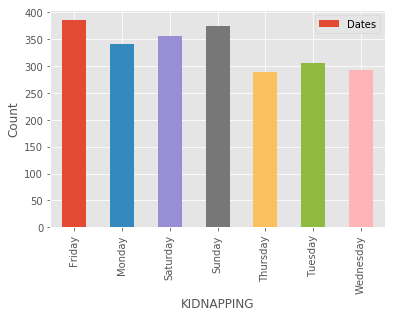

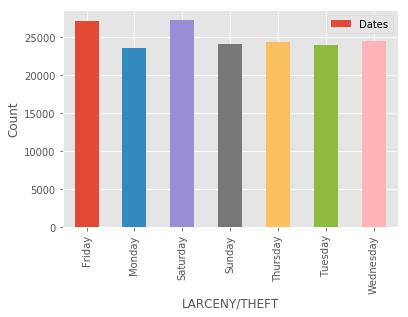

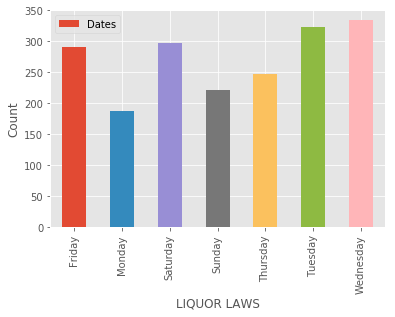

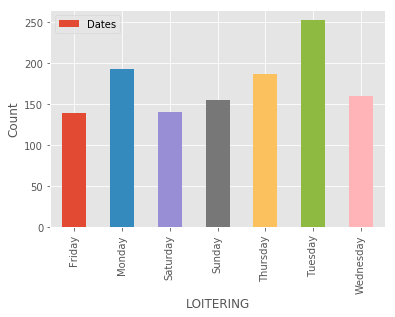

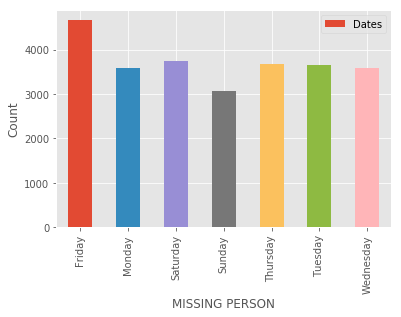

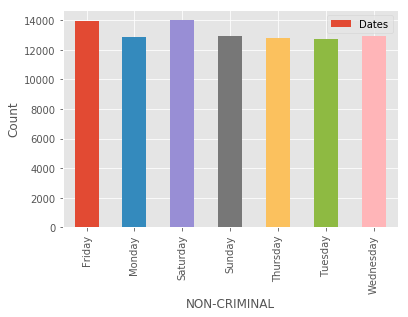

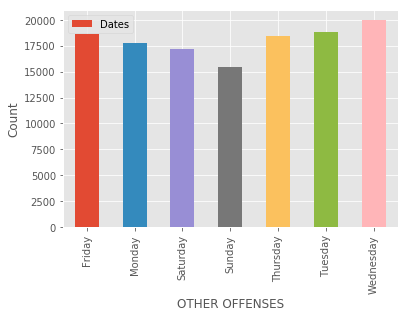

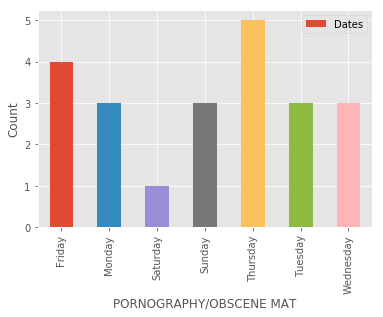

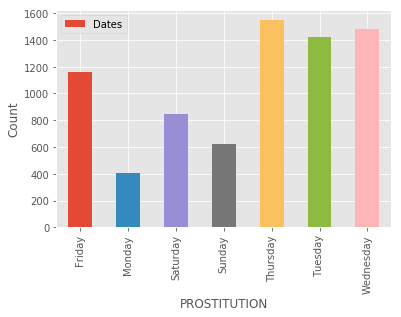

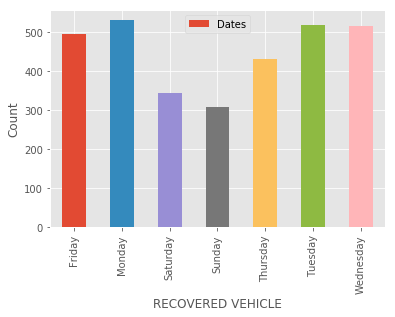

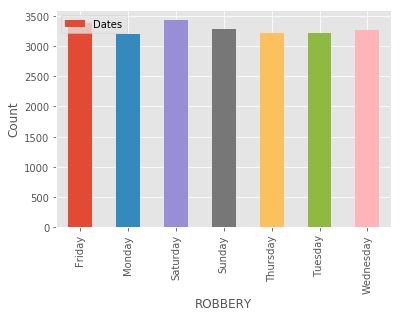

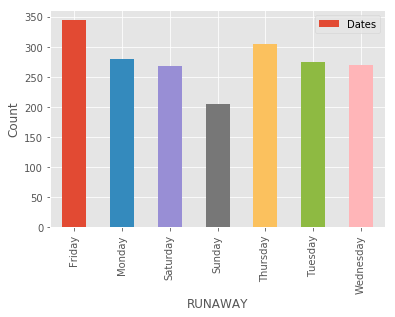

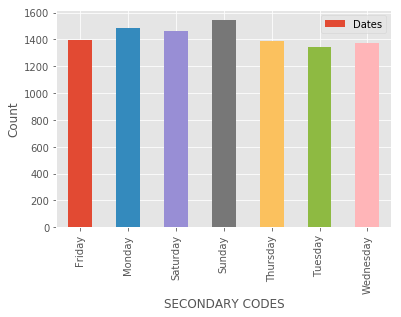

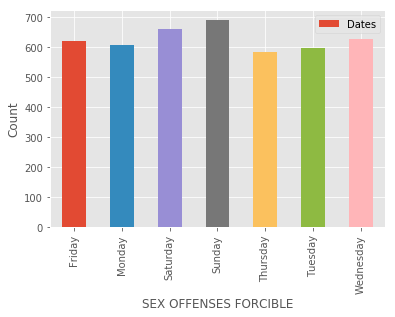

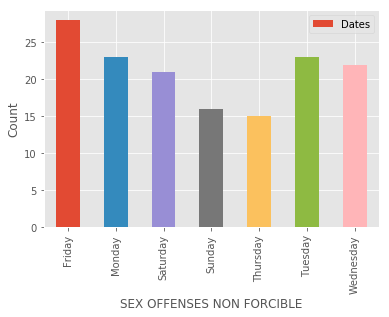

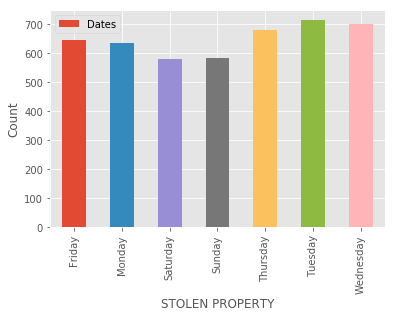

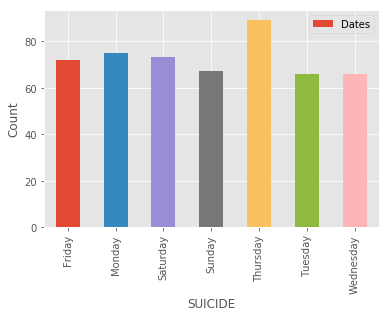

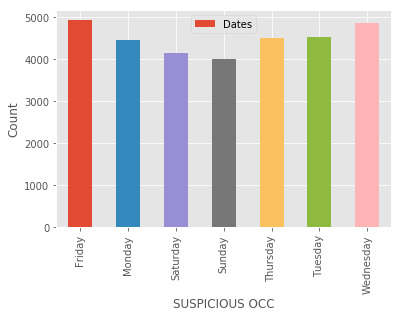

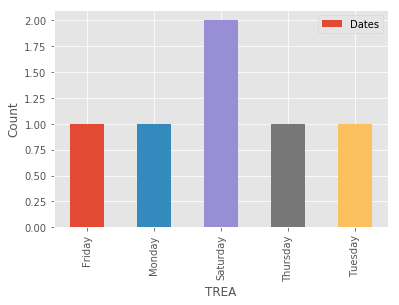

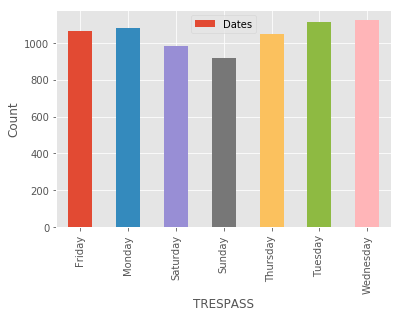

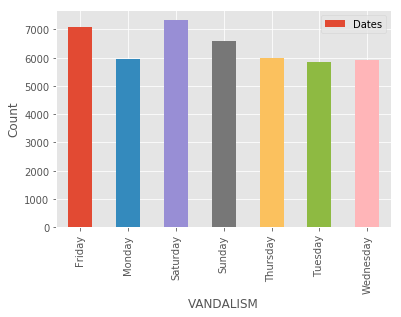

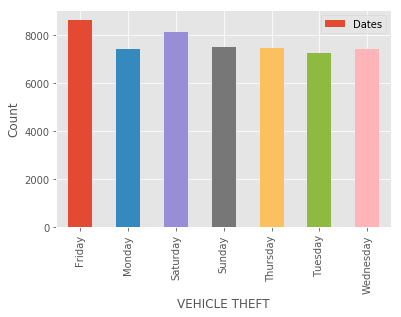

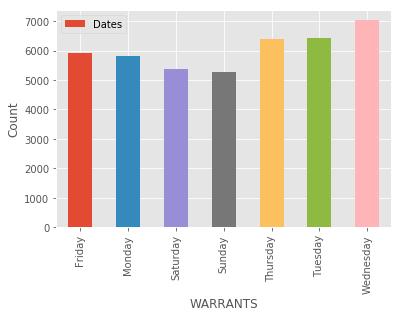

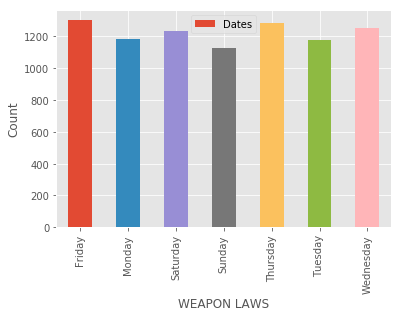

In [20]:
cpddist = data.groupby(['Category', 'DayOfWeek']).count().reset_index()
for category in cpddist['Category'].unique():
    ddata = cpddist[cpddist['Category'] == category]
    ddata.plot.bar(x='DayOfWeek', y='Dates')
    plt.xlabel(category)
    plt.ylabel('Count')

## Number of cases bi-weekly

/usr/local/lib/python3.5/site-packages/pandas/plotting/_core.py:1716: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  series.name = label


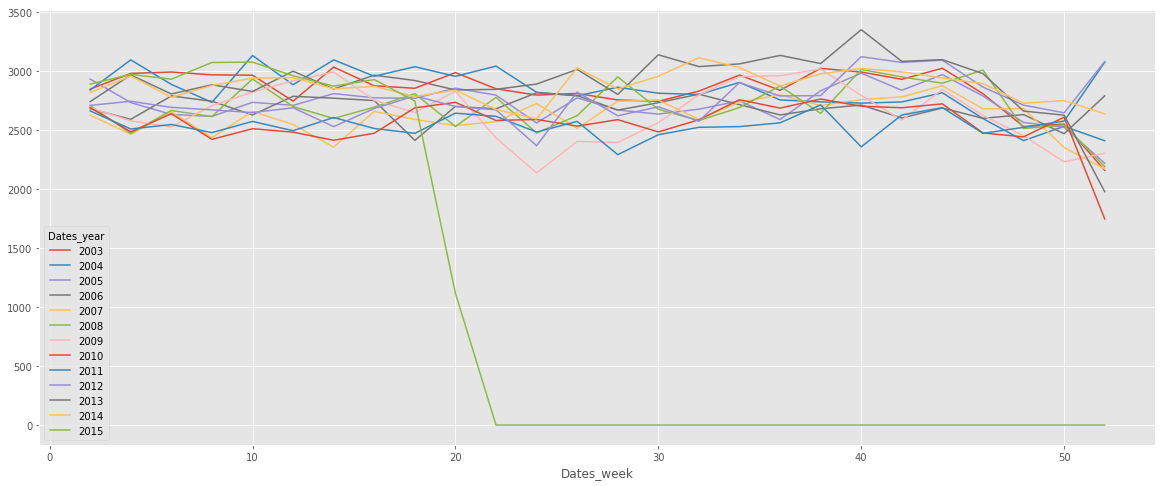

In [21]:
timedata['Dates_week'] = timedata['Dates'].dt.week
weekly = timedata[['Dates_week', 'Dates_year']]
weekly = pd.crosstab([weekly.Dates_week], weekly.Dates_year).reset_index()
grab_dates = weekly.iloc[:, 1:]
weekly.plot(x='Dates_week', y=grab_dates.columns, figsize=(20, 8))

### Takeaways
- The dataset does not contain data past June 2015
- Crime seems to decrease just a bit in the beginning of summer

## Number of cases hourly by PdDistrict

/usr/local/lib/python3.5/site-packages/pandas/plotting/_core.py:1716: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  series.name = label


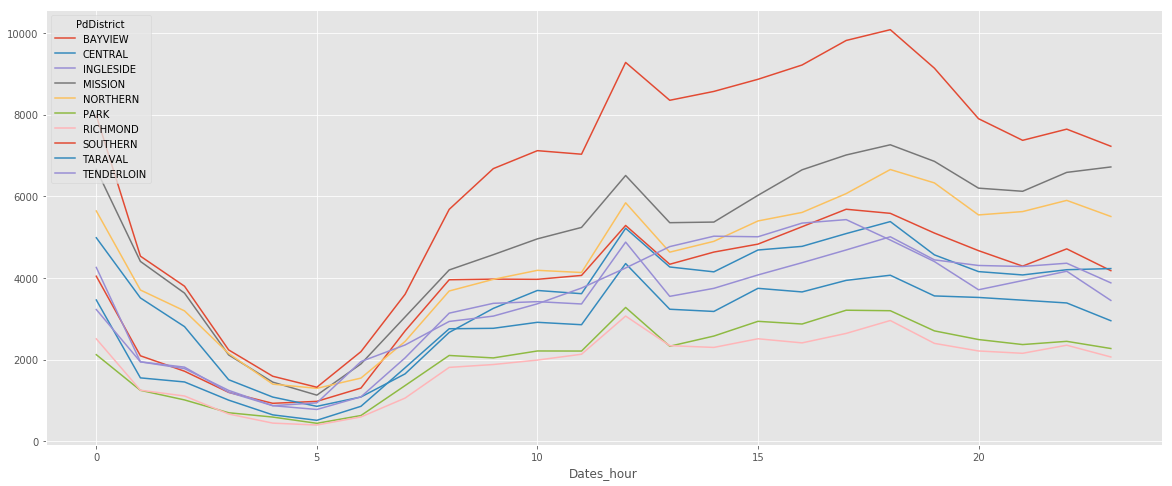

In [22]:
hourly = timedata[['Dates_hour', 'PdDistrict']]
hourly = pd.crosstab([hourly.Dates_hour], hourly.PdDistrict).reset_index()
grab_dists = hourly.iloc[:, 1:]
hourly.plot(x='Dates_hour', y=grab_dists.columns, figsize=(20, 8))
# plt.xticks(np.arange(min(x), max(x)+1, 1.0))

In [23]:
hourly = timedata[['Dates_hour', 'PdDistrict']]
pd.crosstab([hourly.Dates_hour], hourly.PdDistrict).reset_index().sort_values(by='SOUTHERN', ascending=False).head()

PdDistrict,Dates_hour,BAYVIEW,CENTRAL,INGLESIDE,MISSION,NORTHERN,PARK,RICHMOND,SOUTHERN,TARAVAL,TENDERLOIN
18,18,5581,5379,5007,7260,6654,3196,2956,10079,4065,4927
17,17,5681,5085,4684,7010,6064,3208,2640,9815,3939,5427
12,12,5284,5215,4876,6508,5839,3276,3065,9277,4351,4243
16,16,5253,4772,4372,6647,5603,2870,2408,9214,3656,5342
19,19,5098,4564,4441,6854,6326,2702,2396,9136,3558,4400


### Takeaways
- The number of crimes fall between midnight and 5:00am for each district
- Number of crimes increases from 5:00am to 8:00am, level off for a little bit until noon
- The number of crimes jumps up around noon
- The greatest number of crimes occur around 6:00pm
- Ingleside seems to be the only (sort of) anomaly 

## Top 10 address with the most crimes across the years

/usr/local/lib/python3.5/site-packages/pandas/plotting/_core.py:1716: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  series.name = label


Text(0,0.5,'Number of Crimes')

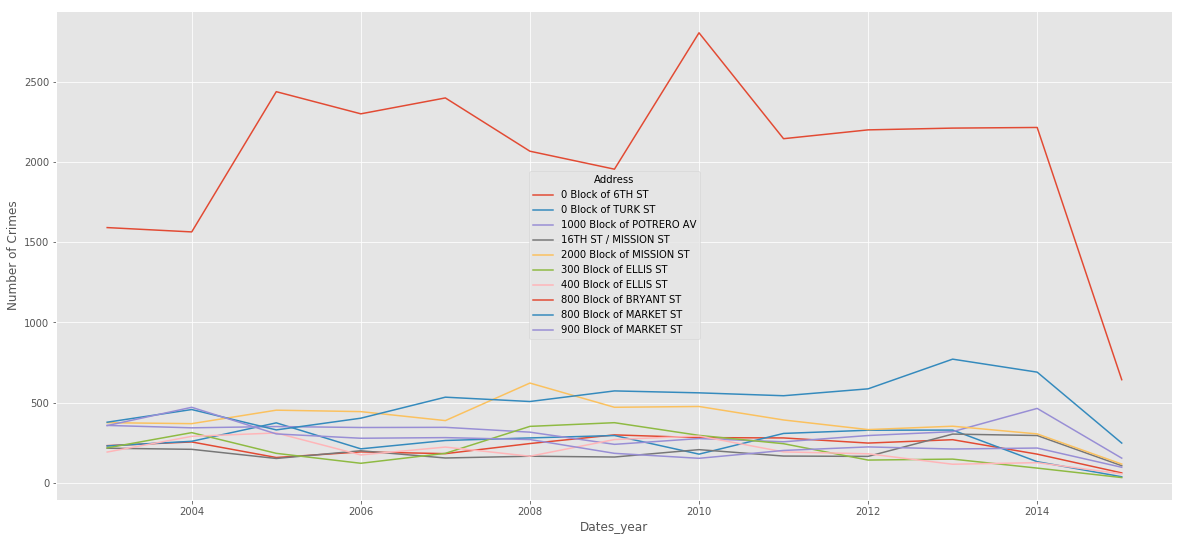

In [24]:
addryear = timedata[(timedata.Address == '800 Block of BRYANT ST') | (timedata.Address == '800 Block of MARKET ST') | 
             (timedata.Address == '2000 Block of MISSION ST') | (timedata.Address == '1000 Block of POTRERO AV') | 
             (timedata.Address == '900 Block of MARKET ST') | (timedata.Address == '0 Block of TURK ST') |
             (timedata.Address == '0 Block of 6TH ST') | (timedata.Address == '300 Block of ELLIS ST') |
             (timedata.Address == '400 Block of ELLIS ST') | (timedata.Address == '16TH ST / MISSION ST')]
addressyear = addryear[['Dates_year', 'Address']]
addressyear = pd.crosstab([addryear.Dates_year], addryear.Address).reset_index()
grab_addresses = addressyear.iloc[:, 1:]
addressyear.plot(x='Dates_year', y=grab_addresses.columns, figsize=(20, 9))
plt.ylabel('Number of Crimes')

In [25]:
timedata.groupby(['Category', 'PdDistrict', 'Address']).count().reset_index().sort_values(by='Dates', ascending=False)

,Category,PdDistrict,Address,Dates,Descript,DayOfWeek,Resolution,X,Y,Dates_year,Dates_month,Dates_day,Dates_hour,Dates_week
60215,LARCENY/THEFT,SOUTHERN,800 Block of BRYANT ST,6144,6144,6144,6144,6144,6144,6144,6144,6144,6144,6144
81356,NON-CRIMINAL,SOUTHERN,800 Block of BRYANT ST,5583,5583,5583,5583,5583,5583,5583,5583,5583,5583,5583
60220,LARCENY/THEFT,SOUTHERN,800 Block of MARKET ST,3256,3256,3256,3256,3256,3256,3256,3256,3256,3256,3256
97141,OTHER OFFENSES,SOUTHERN,800 Block of BRYANT ST,3019,3019,3019,3019,3019,3019,3019,3019,3019,3019,3019
10312,ASSAULT,SOUTHERN,800 Block of BRYANT ST,1926,1926,1926,1926,1926,1926,1926,1926,1926,1926,1926
27174,DRUG/NARCOTIC,MISSION,2000 Block of MISSION ST,1866,1866,1866,1866,1866,1866,1866,1866,1866,1866,1866
167636,WARRANTS,SOUTHERN,800 Block of BRYANT ST,1719,1719,1719,1719,1719,1719,1719,1719,1719,1719,1719
65729,MISSING PERSON,BAYVIEW,1400 Block of PHELPS ST,1468,1468,1468,1468,1468,1468,1468,1468,1468,1468,1468
90954,OTHER OFFENSES,MISSION,2000 Block of MISSION ST,1202,1202,1202,1202,1202,1202,1202,1202,1202,1202,1202
143710,VANDALISM,SOUTHERN,800 Block of BRYANT ST,1155,1155,1155,1155,1155,1155,1155,1155,1155,1155,1155


### Takeaways
- The number of crimes by address stays relatively the same (at least for the top 10 most crime ridden areas) over the years except for 800 Block of BRYANT ST and 800 Block of MARKET ST whicy appear to have a lot of peeks and valleys. This may have to do with the fact that both of these addresses are part of the Southern district--the distict known for having the most criminal actitivity.

# Testing

In [44]:
datareorder = data[['Category', 'Descript', 'Dates', 'DayOfWeek', 'PdDistrict', 'Resolution', 'Address', 'X', 'Y']]
datareorder.head(n=1)

,Category,Descript,Dates,DayOfWeek,PdDistrict,Resolution,Address,X,Y
0,WARRANTS,WARRANT ARREST,2015-05-13 23:53:00,Wednesday,NORTHERN,"ARREST, BOOKED",OAK ST / LAGUNA ST,-122.425892,37.774599


In [45]:
labelencoder = LabelEncoder()
for col in datareorder.columns:
    datareorder[col] = labelencoder.fit_transform(datareorder[col])
datareorder.head()

,Category,Descript,Dates,DayOfWeek,PdDistrict,Resolution,Address,X,Y
0,37,866,389256,6,4,0,19790,18787,23130
1,21,810,389256,6,4,0,19790,18787,23130
2,21,810,389255,6,4,0,22697,19317,32784
3,16,404,389254,6,4,11,4266,18403,32936
4,16,404,389254,6,5,11,1843,13848,21892


## GaussianNB

In [46]:
from sklearn.naive_bayes import GaussianNB
model_naive = GaussianNB()

In [47]:
X = datareorder.iloc[:, 1:] 
y = datareorder.iloc[:, 0]

In [48]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [49]:
model_naive.fit(X_train, y_train)
nb_pred = model_naive.predict(X_test)

In [50]:
accuracy_score(y_test, nb_pred)

0.436097033198565

In [51]:
confusion_matrix(y_test, nb_pred)
# true positive, false negative
# false positive, true negative

array([[    0,   105,     0, ...,     0,     0,     0],
       [    0,  2127,     0, ...,  2476,   314,     0],
       [    0,     1,     0, ...,     0,     0,     0],
       ...,
       [    0,     8,     0, ..., 10097,    77,     0],
       [    0,     3,     0, ...,   273,  2848,     0],
       [    0,    87,     0, ...,    34,    18,     0]])

In [52]:
print(classification_report(y_test, nb_pred, target_names = data['Category'].unique()))

                             precision    recall  f1-score   support

                   WARRANTS       0.00      0.00      0.00       308
             OTHER OFFENSES       0.47      0.14      0.21     15462
              LARCENY/THEFT       0.00      0.00      0.00        85
              VEHICLE THEFT       0.00      0.00      0.00        56
                  VANDALISM       0.47      0.94      0.63      7285
               NON-CRIMINAL       0.00      0.00      0.00       861
                    ROBBERY       0.07      0.93      0.12       435
                    ASSAULT       0.48      0.71      0.58     10766
                WEAPON LAWS       0.83      0.89      0.86       834
                   BURGLARY       1.00      0.04      0.08       236
             SUSPICIOUS OCC       0.00      0.00      0.00        46
                DRUNKENNESS       0.00      0.00      0.00        99
     FORGERY/COUNTERFEITING       0.00      0.00      0.00      2132
              DRUG/NARCOTIC      

/usr/local/lib/python3.5/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


## Decision Trees

In [53]:
from sklearn.tree import DecisionTreeClassifier
model_tree = DecisionTreeClassifier(max_features="auto")

In [54]:
model_tree.fit(X_train, y_train)
tree_pred = model_tree.predict(X_test)

In [55]:
accuracy_score(y_test, tree_pred)

0.8468936848698821

In [56]:
confusion_matrix(y_test, tree_pred)

array([[  115,    63,     0, ...,     4,     1,     8],
       [   66, 12777,     6, ...,   121,    67,    60],
       [    0,     5,    22, ...,     0,     1,     0],
       ...,
       [    7,   107,     0, ..., 10314,    15,     4],
       [    0,    57,     0, ...,    18,  7868,    32],
       [    4,    55,     1, ...,     4,    34,  1058]])

In [57]:
print(classification_report(y_test, tree_pred, target_names=data['Category'].unique()))

                             precision    recall  f1-score   support

                   WARRANTS       0.39      0.37      0.38       308
             OTHER OFFENSES       0.83      0.83      0.83     15462
              LARCENY/THEFT       0.24      0.26      0.25        85
              VEHICLE THEFT       0.27      0.30      0.28        56
                  VANDALISM       0.94      0.94      0.94      7285
               NON-CRIMINAL       0.50      0.53      0.52       861
                    ROBBERY       0.68      0.67      0.68       435
                    ASSAULT       0.92      0.93      0.93     10766
                WEAPON LAWS       0.53      0.53      0.53       834
                   BURGLARY       0.34      0.35      0.35       236
             SUSPICIOUS OCC       0.07      0.11      0.09        46
                DRUNKENNESS       0.17      0.16      0.16        99
     FORGERY/COUNTERFEITING       0.57      0.58      0.57      2132
              DRUG/NARCOTIC      

## Random Forest

In [58]:
from sklearn.ensemble import RandomForestClassifier
model_forest = RandomForestClassifier(max_features="auto") # max_features=20

In [59]:
model_forest.fit(X_train, y_train)
forest_pred = model_forest.predict(X_test)

In [60]:
accuracy_score(y_test, forest_pred)

0.9033540231194124

In [61]:
x = confusion_matrix(y_test, forest_pred)
for item in x:
    print(x)

[[  165    87     0 ...     0     0     0]
 [   20 14356     1 ...    30    27    23]
 [    0     5    14 ...     0     0     0]
 ...
 [    2   104     0 ... 10468     0     0]
 [    0    32     0 ...     4  8138     5]
 [    1   116     1 ...     3    33   915]]
[[  165    87     0 ...     0     0     0]
 [   20 14356     1 ...    30    27    23]
 [    0     5    14 ...     0     0     0]
 ...
 [    2   104     0 ... 10468     0     0]
 [    0    32     0 ...     4  8138     5]
 [    1   116     1 ...     3    33   915]]
[[  165    87     0 ...     0     0     0]
 [   20 14356     1 ...    30    27    23]
 [    0     5    14 ...     0     0     0]
 ...
 [    2   104     0 ... 10468     0     0]
 [    0    32     0 ...     4  8138     5]
 [    1   116     1 ...     3    33   915]]
[[  165    87     0 ...     0     0     0]
 [   20 14356     1 ...    30    27    23]
 [    0     5    14 ...     0     0     0]
 ...
 [    2   104     0 ... 10468     0     0]
 [    0    32     0 ...     4  

In [62]:
print(classification_report(y_test, forest_pred, target_names=data['Category'].unique()))

                             precision    recall  f1-score   support

                   WARRANTS       0.71      0.54      0.61       308
             OTHER OFFENSES       0.84      0.93      0.88     15462
              LARCENY/THEFT       0.44      0.16      0.24        85
              VEHICLE THEFT       0.30      0.12      0.18        56
                  VANDALISM       0.98      0.99      0.98      7285
               NON-CRIMINAL       0.66      0.58      0.62       861
                    ROBBERY       0.79      0.72      0.75       435
                    ASSAULT       0.92      0.95      0.94     10766
                WEAPON LAWS       0.75      0.70      0.72       834
                   BURGLARY       0.41      0.26      0.32       236
             SUSPICIOUS OCC       0.00      0.00      0.00        46
                DRUNKENNESS       0.48      0.20      0.28        99
     FORGERY/COUNTERFEITING       0.70      0.73      0.72      2132
              DRUG/NARCOTIC      

/usr/local/lib/python3.5/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


## Does one-hot encoding improve results?

In [63]:
data.head()

,Dates,Category,Descript,DayOfWeek,PdDistrict,Resolution,Address,X,Y
0,2015-05-13 23:53:00,WARRANTS,WARRANT ARREST,Wednesday,NORTHERN,"ARREST, BOOKED",OAK ST / LAGUNA ST,-122.425892,37.774599
1,2015-05-13 23:53:00,OTHER OFFENSES,TRAFFIC VIOLATION ARREST,Wednesday,NORTHERN,"ARREST, BOOKED",OAK ST / LAGUNA ST,-122.425892,37.774599
2,2015-05-13 23:33:00,OTHER OFFENSES,TRAFFIC VIOLATION ARREST,Wednesday,NORTHERN,"ARREST, BOOKED",VANNESS AV / GREENWICH ST,-122.424363,37.800414
3,2015-05-13 23:30:00,LARCENY/THEFT,GRAND THEFT FROM LOCKED AUTO,Wednesday,NORTHERN,NONE,1500 Block of LOMBARD ST,-122.426995,37.800873
4,2015-05-13 23:30:00,LARCENY/THEFT,GRAND THEFT FROM LOCKED AUTO,Wednesday,PARK,NONE,100 Block of BRODERICK ST,-122.438738,37.771541


#### Must use dask because of memory error that occurs with pandas

In [64]:
dask = dd.read_csv("crimetrain.csv", parse_dates=['Dates'])
# dropping some columns because memory errors are still occuring. Dropping Descript because keeping it 
# feels like cheating anyway, as well as DayOfWeek, X, and Y. Dropping Category so dask doesn't one hot encode it
dask = dask.drop(['Category', 'Descript', 'DayOfWeek', 'X', 'Y'], axis=1)
# telling dask what columns are categorical for one hot
dask = dask.categorize(columns=['PdDistrict', 'Resolution', 'Address'])
# moving columns around
dask = dask[['Dates', 'PdDistrict', 'Resolution', 'Address']]

In [65]:
dask.columns

Index(['Dates', 'PdDistrict', 'Resolution', 'Address'], dtype='object')

In [66]:
# one hot encoding categorical data
enc = DummyEncoder(["PdDistrict", "Resolution", "Address"])

In [67]:
enc

DummyEncoder(columns=['PdDistrict', 'Resolution', 'Address'],
       drop_first=False)

In [68]:
dask = enc.fit_transform(dask)

In [69]:
dask.columns

Index(['Dates', 'PdDistrict_NORTHERN', 'PdDistrict_PARK',
       'PdDistrict_INGLESIDE', 'PdDistrict_BAYVIEW', 'PdDistrict_RICHMOND',
       'PdDistrict_CENTRAL', 'PdDistrict_TARAVAL', 'PdDistrict_TENDERLOIN',
       'PdDistrict_MISSION',
       ...
       'Address_200 Block of BUENA VISTA EAST AV',
       'Address_SAN BRUNO AV / WABASH TR', 'Address_0 Block of DEL MONTE ST',
       'Address_CLEMENTINA ST /', 'Address_0 Block of SANTA YSABEL AV',
       'Address_ALERT AL / DOLORES ST',
       'Address_CALIFORNIA ST / COMMONWEALTH AV',
       'Address_300 Block of JOHN F KENNEDY DR', 'Address_FOLSOM ST / ZENO PL',
       'Address_1000 Block of 22ND AV'],
      dtype='object', length=23256)

In [72]:
# prints every column in dask
# cols = list(dask.columns[0:])
# cols
# dask[cols].compute()

In [75]:
# the kernel keeps dying here
# Xoh = dask 
# yoh = datareorder.iloc[:, 0]
# Xoh_train, Xoh_test, yoh_train, yoh_test = train_test_split(Xoh, yoh, test_size=0.2)

In [ ]:
# model_forest.fit(X_train, y_train)
# forest_pred = model_forest.predict(X_test)

The kernel keeps dying everytime I try to split the data into a train and test set. Seeing if labeling encoding the data improves results will have to wait until another time.

## How does dropping the Descript column (the column having the highest correlation with Category) compare to the previous Random Forest model?

In [76]:
dropDes = datareorder.drop(["Descript"], axis=1)
dropDes.head()

,Category,Dates,DayOfWeek,PdDistrict,Resolution,Address,X,Y
0,37,389256,6,4,0,19790,18787,23130
1,21,389256,6,4,0,19790,18787,23130
2,21,389255,6,4,0,22697,19317,32784
3,16,389254,6,4,11,4266,18403,32936
4,16,389254,6,5,11,1843,13848,21892


In [77]:
XdropDes = dropDes.iloc[:, 1:] 
ydropDes = dropDes.iloc[:, 0]

In [78]:
XdropDes_train, XdropDes_test, ydropRes_train, ydropDes_test = train_test_split(XdropDes, ydropDes, test_size=0.2)

In [79]:
model_forestDropDes = RandomForestClassifier(max_features="auto") # max_features=20
model_forestDropDes.fit(XdropDes, ydropDes)
forest_predDropDes = model_forestDropDes.predict(XdropDes_test)

In [80]:
accuracy_score(ydropDes_test, forest_predDropDes)

0.8422128580376972

In [81]:
confusion_matrix(ydropDes_test, forest_predDropDes)

array([[  239,     5,     0, ...,     2,     1,     5],
       [    0, 12689,     2, ...,    15,   172,    97],
       [    0,     1,    67, ...,     1,     0,     0],
       ...,
       [    4,    27,     0, ..., 10288,    12,     2],
       [    1,   232,     0, ...,    15,  5558,    61],
       [    0,   117,     0, ...,     2,    63,  1122]])

In [82]:
print(classification_report(ydropDes_test, forest_predDropDes, target_names=data['Category'].unique()))

                             precision    recall  f1-score   support

                   WARRANTS       0.90      0.85      0.87       282
             OTHER OFFENSES       0.79      0.83      0.81     15270
              LARCENY/THEFT       0.79      0.83      0.81        81
              VEHICLE THEFT       0.52      0.40      0.45        55
                  VANDALISM       0.89      0.87      0.88      7357
               NON-CRIMINAL       0.60      0.56      0.58       820
                    ROBBERY       0.78      0.69      0.73       463
                    ASSAULT       0.73      0.81      0.77     10993
                WEAPON LAWS       0.57      0.50      0.53       859
                   BURGLARY       0.81      0.81      0.81       220
             SUSPICIOUS OCC       0.63      0.63      0.63        46
                DRUNKENNESS       0.75      0.75      0.75        81
     FORGERY/COUNTERFEITING       0.82      0.81      0.81      2177
              DRUG/NARCOTIC      

/usr/local/lib/python3.5/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


## Summary

Out of the GaussianNB, Decision Tree, and Random Forest classifiers, the Random Forest Classifier performed the best concerning accuracy with a score of .92 (remarkably better than the Gaussian's and Decision Tree's .44 and .77 respectively), and most likely the confusion matrix as well, though it is difficult to be certain as the confusion matrix is so big that it is hard to print out in a readable format. Additionally, after removing the Descript column, the Random Forest classifier did noteably worse (accuracy score of .84) as expected given that Descript had the highest correlation with the Category variable that we were trying to predict. One hot encoding everything still needs to be desired as well as attempting to classify the data using SVM and Logistic Regression.